In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
photo = plt.imread('data/flowers/photo.jpg', format='jpeg')
depth = plt.imread('data/flowers/depth.jpg', format='jpeg')

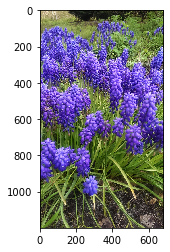

In [3]:
plt.imshow(photo)

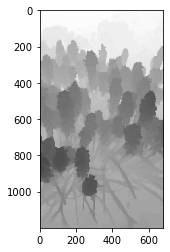

In [4]:
plt.imshow(depth)

bright is high, dark is low

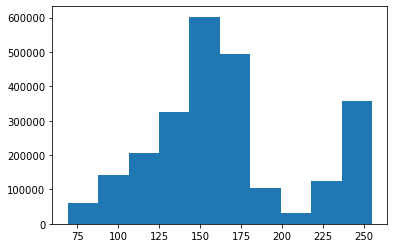

In [77]:
plt.hist(depth.flatten())
plt.show()

In [7]:
# all units in mm

In [90]:
f_base = 1.
f_target = 100.

In [91]:
# 1m = 1000mm
closest_point = .1*1000.
furthest_point = 100*1000.
print (closest_point, furthest_point)

100.0 100000.0


In [122]:
def rescale_to_range(m, rescaled_range=None):
    minm, maxm = m.min(), m.max()
    mnew = (m-minm)/(maxm-minm)
    if rescaled_range is None:
        return mnew
    else:
        mintgt, maxtgt = rescaled_range
        return mintgt+(maxtgt-mintgt)*mnew

In [123]:
distance = rescale_to_range(depth/255)
distance = np.exp(distance)/np.exp(1)
distance = closest_point + (furthest_point-closest_point)*distance

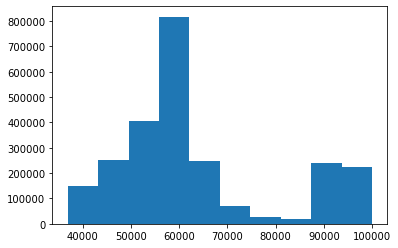

In [124]:
plt.hist(distance.flatten())
plt.show()

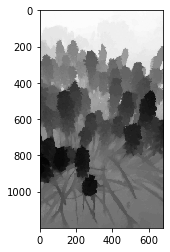

In [125]:
plt.imshow(distance[:,:,0], cmap='Greys_r')

In [126]:
class Optic:
    
    def __init__(self, f):
        self.f = f
        
    def image_distance(self, depth_in_mm):
        assert depth_in_mm.min() > self.f, \
        'check that depth_in_mm.min() = %s > self.focal = %s' % (depth_in_mm.min(), self.f)
        return 1/(np.ones(depth_in_mm.shape)/self.f - 1/depth_in_mm)

In [216]:
def get_magnification(f_base, f_target, d):
    optic_base = Optic(f_base)
    optic_target = Optic(f_target)
    return optic_target.image_distance(d)/optic_base.image_distance(d)

In [266]:
magnification = 1/get_magnification(f_base, f_target, distance)
magnification = rescale_to_range(magnification, (1, 2))
# magnification = magnification/magnification.min()

In [267]:
nbins=3

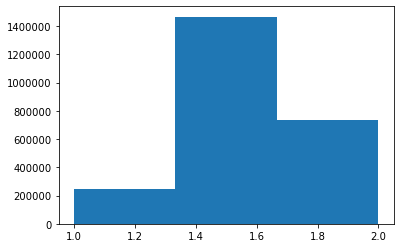

In [268]:
_, magbins, _ = plt.hist(magnification.flatten(), bins=nbins)

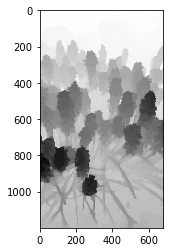

In [269]:
plt.imshow(magnification[:,:,0], cmap='Greys_r')

In [270]:
from skimage.transform import rescale

In [271]:
def get_magnified_segment(bindex):
    binmag = magbins[bindex]
    binmaglower = magbins[bindex-1]
    
    rescale_args = binmag
    photomag = rescale(photo, rescale_args)
    magmap = rescale(magnification, rescale_args)
    height, width, _ = photomag.shape
    
    segmap = np.logical_and(magmap >= binmaglower, magmap <= binmag)
    photoseg = np.zeros(photomag.shape)
    photoseg[segmap] = photomag[segmap]
    alphaseg = np.zeros((height, width, 1))
    alphaseg[segmap[:,:,0]] = 1.
    return np.concatenate([photoseg, alphaseg], axis=2)

In [272]:
segments = [get_magnified_segment(i) for i in range(nbins, 0, -1)]

In [273]:
for segment in segments:
    print (segment.shape, segment[0,0,:])

(2400, 1360, 4) [0.75588235 0.71666667 0.5245098  1.        ]
(2000, 1133, 4) [0. 0. 0. 0.]
(1600, 907, 4) [0. 0. 0. 0.]


In [274]:
from skimage.util import pad

In [275]:
segments_aligned = [segments[0]]

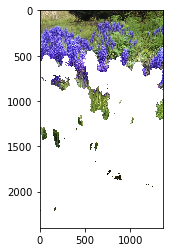

1


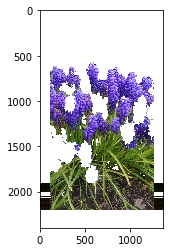

2


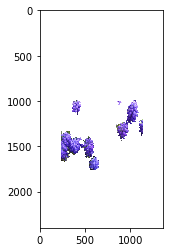

In [276]:
baseimage = segments[0]
plt.imshow(baseimage)
plt.show()
heightout, widthout, _ = baseimage.shape

for i in range(1, len(segments)):
    print (i)
    segment = segments[i]
    heighttemp, widthtemp, _ = segment.shape
    heightdiff, widthdiff = (heightout - heighttemp)/2, (widthout - widthtemp)/2
    pad_width = ((int(heightdiff), int(heightdiff+.999)), 
                 (int(widthdiff), int(widthdiff+.999)),
                 (0, 0))
    additivetemp = pad(segment, pad_width=pad_width, mode='minimum')
    plt.imshow(additivetemp)
    plt.show()
    segments_aligned.append(additivetemp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


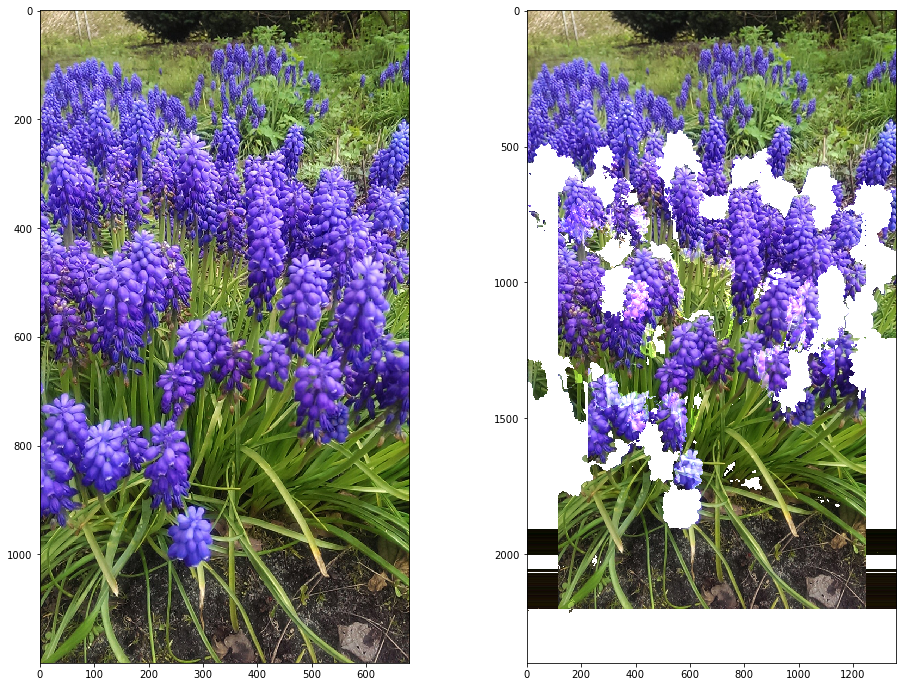

In [277]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 12))
ax[0].imshow(photo)
ax[1].imshow(sum(segments_aligned))